# Differentiable Physics III: Finite Difference Method

We define a regular grid of cells, where each cell has a size of $\Delta x \times \Delta y$. On this grid we define a scalar field $f$ and a vector field $u$.

## Calculus Preliminaries

Common operators for scalar $f$ and vector fields $v$ used in this context:

| Operator | Symbol | Description | Intuition |
| --- | --- | --- | --- |
| Gradient | $\nabla$ | $\nabla f = \begin{bmatrix} \frac{\partial f}{\partial x} \\ \frac{\partial f}{\partial y} \end{bmatrix}$ | Slope of a mountain |
| Divergence | $\nabla \cdot$ | $\nabla \cdot \vec{u} = \frac{\partial u_x}{\partial x} + \frac{\partial u_y}{\partial y}$ | Inflow minus outflow |
| Laplacian | $\nabla^2$ | $\nabla^2 f = \Delta f = \frac{\partial^2 f}{\partial x^2} + \frac{\partial^2 f}{\partial y^2}$ | Linear slope has zero laplacian, peak has high negative |
| Curl | $\nabla \times$ | $\nabla \times \vec{u} = \frac{\partial u_y}{\partial x} - \frac{\partial u_x}{\partial y}$ | Rotation of a vector field |
| Jacobian | $J$ | $J v = \begin{bmatrix} \frac{\partial u_x }{\partial x} & \frac{\partial u_x }{\partial y} \\ \frac{\partial u_y }{\partial x} & \frac{\partial u_y }{\partial y} \end{bmatrix}$ | Change of variables |
| Hessian | $H$ | $H f = \begin{bmatrix} \frac{\partial^2 f}{\partial x^2} & \frac{\partial^2 f}{\partial x \partial y} \\ \frac{\partial^2 f}{\partial y \partial x} & \frac{\partial^2 f}{\partial y^2} \end{bmatrix}$ | Change of variables |


## Finite Difference Method

In a discrete setting we can approximate common operations as follows:

| Operation | Formula | Numerical Approximation |
| --- | --- | --- |
| Forward Difference | $\frac{\partial u}{\partial x}$ | $\frac{u_{i+i, j} - u_{i,j}}{\Delta x}$ |
| Backward Difference | $\frac{\partial u}{\partial x}$ | $\frac{u_{i, j} - u_{i-1,j}}{\Delta x}$ |
| Central Difference | $\frac{\partial u}{\partial x}$ | $\frac{u_{i+1, j} - u_{i-1,j}}{2 \Delta x}$ |
| Second Order Central | $\frac{\partial^2 u}{\partial x^2}$ | $\frac{u_{i+1, j} - 2 u_{i,j} + u_{i-1,j}}{\Delta x^2}$ |
| Second Order Forward | $\frac{\partial^2 u}{\partial x^2}$ | $\frac{u_{i+2, j} - 2 u_{i+1,j} + u_{i,j}}{\Delta x^2}$ |
| Second Order Backward | $\frac{\partial^2 u}{\partial x^2}$ | $\frac{u_{i, j} - 2 u_{i-1,j} + u_{i-2,j}}{\Delta x^2}$ |
| Gradient | $\nabla f$ | $\begin{bmatrix} \frac{f_{i+1, j} - f_{i-1,j}}{2 \Delta x} \\ \frac{f_{i, j+1} - f_{i,j-1}}{2 \Delta y} \end{bmatrix}$ |
| Divergence | $\nabla \cdot \vec{u}$ | $\frac{u_{i+1, j} - u_{i-1,j}}{2 \Delta x} + \frac{u_{i, j+1} - u_{i,j-1}}{2 \Delta y}$ |
| Laplacian | $\nabla^2 f$ | $\frac{f_{i+1, j} - 2 f_{i,j} + f_{i-1,j}}{\Delta x^2} + \frac{f_{i, j+1} - 2 f_{i,j} + f_{i,j-1}}{\Delta y^2}$ |

Note that for the gradient, divergence and laplacian any of the forward, backward and central difference schemes could be used. Usually the exact choice differs from solver to solver and can be very crucial.

In order to get a better intuition for some of the operations we generate a sample scalar field $f$ and a sample vector field $u$.


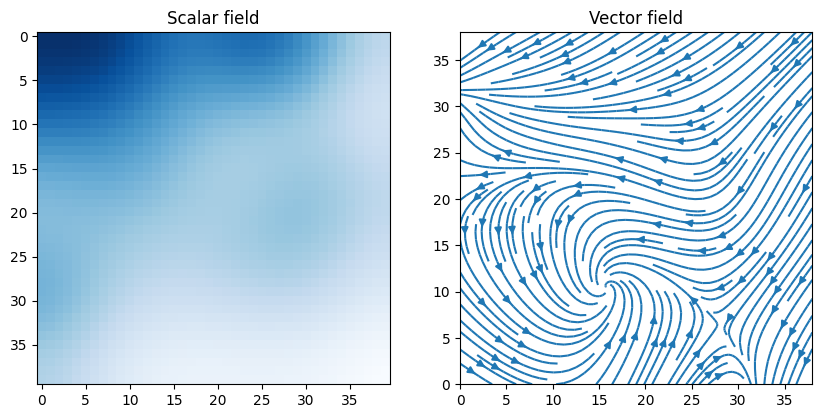

In [54]:
import numpy as np
import matplotlib.pyplot as plt
# import convolve ndimage
from scipy.ndimage import convolve

np.random.seed(5)

def coherent_noise(grid_size_sparse : int, grid_size_dense : int, seed=None) -> np.ndarray:
    # Sparse and dense random sampling
    values_sparse = np.random.random((grid_size_sparse, grid_size_sparse))

    stride = grid_size_dense // grid_size_sparse
    values_dense = np.zeros((grid_size_dense, grid_size_dense))
    values_dense[::stride, ::stride] = values_sparse

    # Blur kernel
    kernel = np.array([[1, 2, 1],[2, 4, 2],[1, 2, 1]]) / 16

    for i in range(grid_size_dense // grid_size_sparse * 10):
        values_dense = convolve(values_dense, kernel)

    max = np.max(values_dense)
    min = np.min(values_dense)

    values_dense = (values_dense - min) / (max - min)

    return values_dense

grid_size = 40
noise_x = coherent_noise(5, grid_size)
noise_y = coherent_noise(5, grid_size)

noise_x -= 0.5
noise_y -= 0.5

noise_xy = np.stack([noise_x, noise_y], axis=-1)
noise_xyz = np.stack([noise_x, noise_y, np.zeros_like(noise_x)], axis=-1)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].set_title("Scalar field")
axs[0].imshow(noise_x, cmap="Blues")
# set size of axis 
axs[0].set_aspect('equal', 'box')


def streamplot(field : np.ndarray, size : int, axis : plt.Axes, stride : int):
    X = np.arange(0, size, 1)
    Y = np.arange(0, size, 1)
    axis.streamplot(X[::stride], Y[::stride], field[::stride, ::stride, 0], field[::stride, ::stride, 1], density=1.5)
    axis.set_aspect('equal', 'box')


axs[1].set_title("Vector field")
streamplot(noise_xy, grid_size, axs[1], 2)


Now we can apply the listed operators to the fields.

In [55]:
def forward_difference(field : np.ndarray, axis : int, delta : float) -> np.ndarray:
    padded_field = np.pad(field, 1, mode="edge")
    field_r = np.roll(field, 1, axis=axis)
    return (field_r - field) / delta

def backward_difference(field : np.ndarray, axis : int, delta : float) -> np.ndarray:
    field_l = np.roll(field, -1, axis=axis)
    return (field - field_l) / delta

def central_difference(field : np.ndarray, axis : int, delta : float) -> np.ndarray:
    field_r = np.roll(field, 1, axis=axis)
    field_l = np.roll(field, -1, axis=axis)
    return (field_r - field_l) / (2 * delta)
    

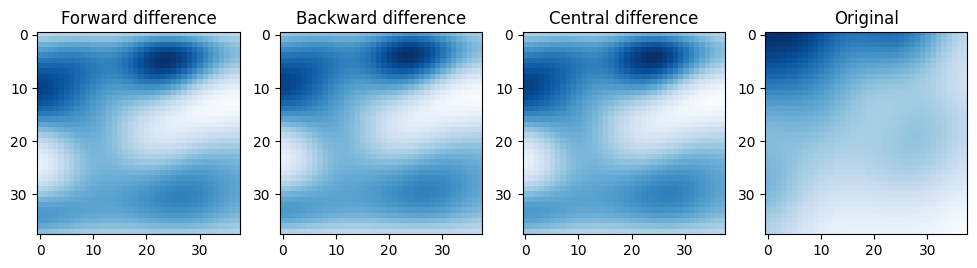

In [56]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

axs[0].set_title("Forward difference")
axs[0].imshow(forward_difference(noise_x, 0, 1)[1:-1,1:-1], cmap="Blues")
axs[0].set_aspect('equal', 'box')

axs[1].set_title("Backward difference")
axs[1].imshow(backward_difference(noise_x, 0, 1)[1:-1,1:-1], cmap="Blues")
axs[1].set_aspect('equal', 'box')

axs[2].set_title("Central difference")
axs[2].imshow(central_difference(noise_x, 0, 1)[1:-1,1:-1], cmap="Blues")
axs[2].set_aspect('equal', 'box')

axs[3].set_title("Original")
axs[3].imshow(noise_x[1:-1,1:-1], cmap="Blues")

In [57]:
def second_order_central_difference(field : np.ndarray, axis : int, delta : float) -> np.ndarray:
    field_r = np.roll(field, 1, axis=axis)
    field_l = np.roll(field, -1, axis=axis)
    return (field_r - 2 * field + field_l) / (delta ** 2)

def second_order_forward_difference(field : np.ndarray, axis : int, delta : float) -> np.ndarray:
    field_r = np.roll(field, 1, axis=axis)
    field_rr = np.roll(field, 2, axis=axis)
    return (field_rr - 2 * field_r + field) / (delta ** 2)

def second_order_backward_difference(field : np.ndarray, axis : int, delta : float) -> np.ndarray:
    field_l = np.roll(field, -1, axis=axis)
    field_ll = np.roll(field, -2, axis=axis)
    return (field - 2 * field_l + field_ll) / (delta ** 2)

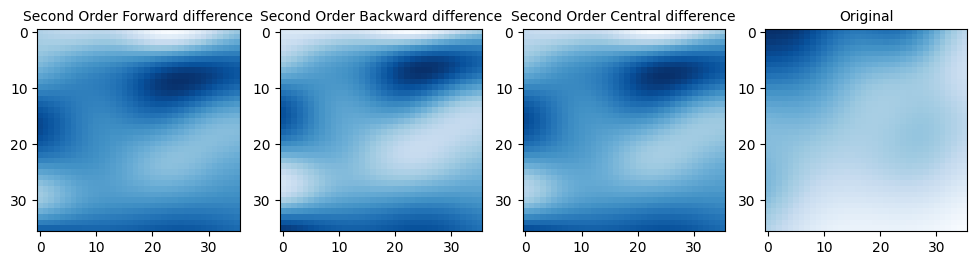

In [58]:
fig, axs = plt.subplots(1, 4, figsize=(12, 3))

axs[0].set_title("Second Order Forward difference", fontsize=10)
axs[0].imshow(second_order_forward_difference(noise_x, 0, 1)[2:-2,2:-2], cmap="Blues")
axs[0].set_aspect('equal', 'box')

axs[1].set_title("Second Order Backward difference", fontsize=10)
axs[1].imshow(second_order_backward_difference(noise_x, 0, 1)[2:-2,2:-2], cmap="Blues")
axs[1].set_aspect('equal', 'box')

axs[2].set_title("Second Order Central difference", fontsize=10)
axs[2].imshow(second_order_central_difference(noise_x, 0, 1)[2:-2,2:-2], cmap="Blues")
axs[2].set_aspect('equal', 'box')

axs[3].set_title("Original", fontsize=10)
axs[3].imshow(noise_x[2:-2,2:-2], cmap="Blues")


In [59]:
def gradient(field : np.ndarray, delta : float) -> np.ndarray:
    grad_x = central_difference(field, 0, delta)
    grad_y = central_difference(field, 1, delta)
    return np.stack([grad_x, grad_y], axis=-1)

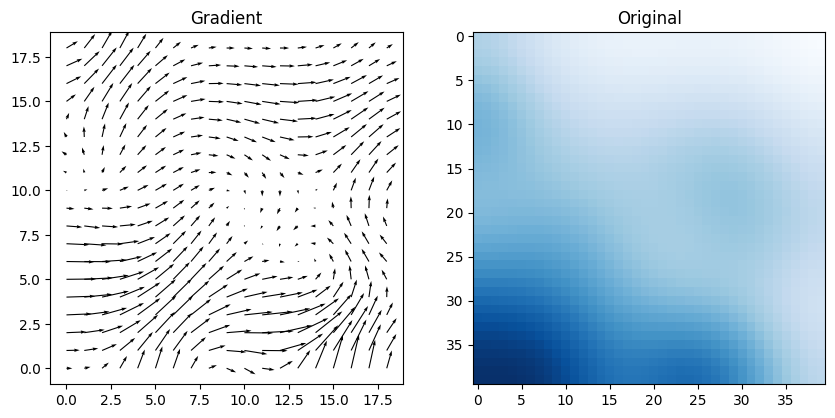

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title("Gradient")
axs[0].quiver(gradient(noise_x, 1)[1:-1:2,1:-1:2,0], gradient(noise_x, 1)[1:-1:2,1:-1:2,1], scale=0.5)
axs[0].set_aspect('equal', 'box')

axs[1].set_title("Original")
noise_x_flipped = np.flip(noise_x, axis=0)
axs[1].imshow(noise_x_flipped, cmap="Blues")
axs[1].set_aspect('equal', 'box')

In [79]:
def divergence(field : np.ndarray, delta : float) -> np.ndarray:
    grad_x = central_difference(field[..., 0], 0, delta)
    grad_y = central_difference(field[..., 1], 1, delta)
    return grad_x + grad_y

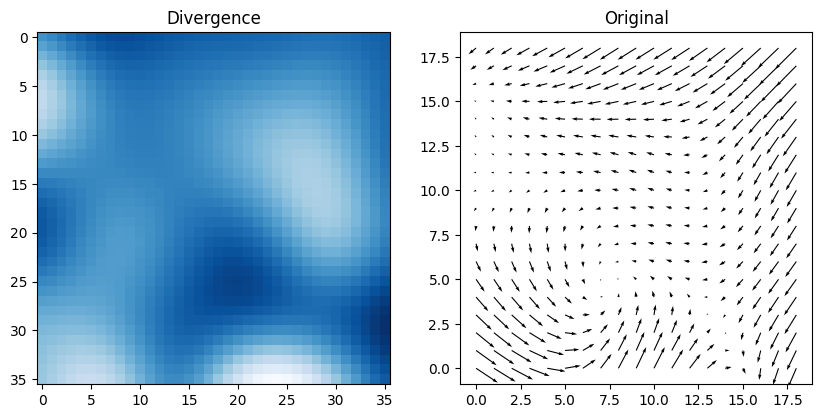

In [83]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title("Divergence")
divg = divergence(gradient(noise_x, 1), 1)
divg = np.flip(divg, axis=0)
axs[0].imshow(divg[2:-2,2:-2], cmap="Blues")
axs[0].set_aspect('equal', 'box')

axs[1].set_title("Original")
axs[1].quiver(noise_xy[1:-1:2,1:-1:2,0], noise_xy[1:-1:2,1:-1:2,1], scale=8.0)
axs[1].set_aspect('equal', 'box')

In [81]:
def laplacian (field : np.ndarray, delta : float) -> np.ndarray:
    return second_order_central_difference(field, 0, delta) + second_order_central_difference(field, 1, delta)

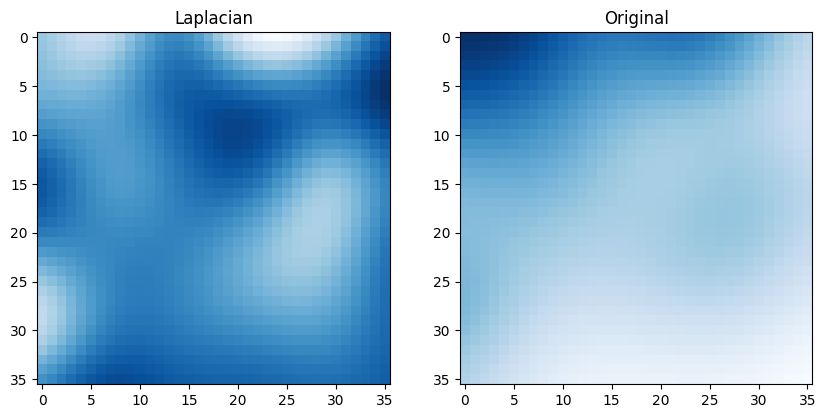

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title("Laplacian")
axs[0].imshow(laplacian(noise_x, 1)[2:-2,2:-2], cmap="Blues")
axs[0].set_aspect('equal', 'box')

axs[1].set_title("Original")
axs[1].imshow(noise_x[2:-2,2:-2], cmap="Blues")
axs[1].set_aspect('equal', 'box')

## Finite Difference Method and Discretization

We can approximate the derivatives of a function $f$ with respect to $x$ and $y$ as using the **forward difference** method:

$$\frac{\partial f}{\partial x} \approx \frac{f(x + \Delta x, y) - f(x, y)}{\Delta x}$$

When we use a uniform grid:

$$\frac{\partial f}{\partial x} \approx \frac{f_{i+1, j} - f_{i, j}}{\Delta x}$$

Analagously we can approximate the **backward difference** as:

$$\frac{\partial f}{\partial x} \approx \frac{f_{i, j} - f_{i-1, j}}{\Delta x}$$

And the **central difference** as:

$$\frac{\partial f}{\partial x} \approx \frac{f_{i+1, j} - f_{i-1, j}}{2 \Delta x}$$

We can compose these approximations to get the following approximations for the second derivatives. The **second order central difference**:

$$\frac{\partial^2 f}{\partial x^2} \approx \frac{f_{i+1, j} - 2 f_{i, j} + f_{i-1, j}}{\Delta x^2}$$
